In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# INSTALL LIBRARY

In [2]:
!pip install pyvi
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emoji: filename=emoji-2.7.0-py2.py3-none-any.whl size=356563 sha256=f6060229fcae34cb7c8448855790b5b022a8f4ce4a9104a9681d0217cc98f931
  Stored in directory: /root/.cache/pip/wheels/41/11/48/5df0b9727d5669c9174a141134f10304d1d78a3b89a4676f3d
Successfully built emoji


In [3]:
!pip install wikiextractor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 1.6 MB/s eta 0:00:00


# IMPORT LIBRARY

In [128]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyvi import ViTokenizer, ViPosTagger
import emoji
import re
import gensim
import copy
from sklearn.metrics import confusion_matrix, f1_score

# ADD DATA SET

In [27]:
PATH = '/content/drive/MyDrive/Sentiment Analisys (UIT VSMEC Data set)/'
train_file_name = 'train_nor_811.xlsx'
test_file_name = 'test_nor_811.xlsx'

In [28]:
train_frame = pd.read_excel(PATH+train_file_name)
train_frame.head()

,Unnamed: 0,Emotion,Sentence
0,188,Other,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [29]:
test_frame = pd.read_excel(PATH+test_file_name)
test_frame.head()

,Unnamed: 0,Emotion,Sentence
0,713,Sadness,người ta có bạn bè nhìn vui thật
1,1827,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật
2,1166,Disgust,kinh vãi 😡
3,228,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4,1942,Anger,bố không thích nộp đấy mày thích ý kiến không


In [30]:
train_frame.columns

Index(['Unnamed: 0', 'Emotion', 'Sentence'], dtype='object')

In [31]:
train_frame.drop('Unnamed: 0',axis='columns', inplace=True)
test_frame.drop('Unnamed: 0',axis='columns', inplace=True)

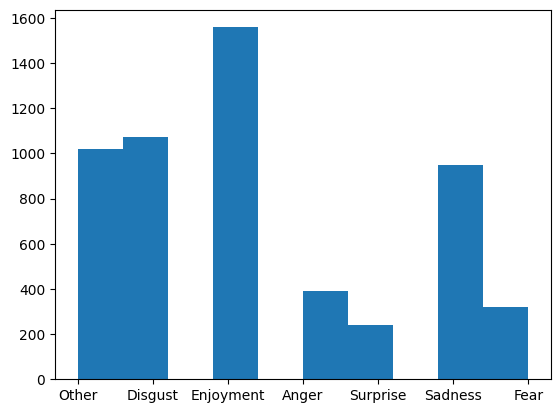

In [32]:
plt.hist(train_frame['Emotion'])
plt.show()

#PREPROCESSING

In [33]:
def preprocessEmoji(sentence):
  emotion_dict = {
      '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
      '(-_-)|(-\.-)':'😐',':v':'_pacman_smile_','(:|;|=)+(\'|`|\")+(\)|\]|>)+':'🥲','(:|;|=)+(\'|`|\")+(\(|\[|<)+':'😢',
      '@@':'😵‍💫','đc':'được','đk':'được','bik':'biết','ngừi':'người','hix':'hic','lm':'làm'
  }
  for key, value in emotion_dict.items():
    sentence = re.sub(key,value,sentence)
  sentence = emoji.demojize(sentence)
  sentence = re.sub(r":(.*?):",r" _\1_ ",sentence)
  sentence = re.sub(r'([!@#$%^&*()_+={}\[\]:;"\'<>,?/\\|~-])\1+',r'\1',sentence)
  return sentence

In [34]:
def tokenize(sentence):
  start_token = ' _s_ '
  end_token = ' _e_ '
  sentence = sentence.lower()
  sentence = preprocessEmoji(sentence)
  sentence = start_token+sentence+end_token
  return ViTokenizer.tokenize(sentence).split()


In [35]:
train_frame['Sentence'] = train_frame['Sentence'].apply(preprocessEmoji)
train_frame['Sentence'] = train_frame['Sentence'].apply(tokenize)
train_frame

,Emotion,Sentence
0,Other,"[_s_, cho, mình, xin, bài, nhạc, tên, là, gì, ..."
1,Disgust,"[_s_, cho, đáng_đời, con, quỷ, ., về, nhà, lôi..."
2,Disgust,"[_s_, lo, học, đi, ., yêu_đương, lol, gì, hay,..."
3,Enjoyment,"[_s_, uớc, gì, sau_này, về, già, vẫn, có_thể, ..."
4,Enjoyment,"[_s_, mỗi, lần, có, video, của, con, là, cứ, c..."
...,...,...
5543,Disgust,"[_s_, đường, của, nhà_cụ, hay, sao, mà, cụ, cấ..."
5544,Other,"[_s_, nhìn, mặt, héo, queo, luôn, _e_]"
5545,Other,"[_s_, tao, đi, xe_máy, mỗi, lần, muốn, để, xe,..."
5546,Enjoyment,"[_s_, thích, thân_hình, boss, rồi, nhan, _reli..."


In [36]:
test_frame['Sentence'] = test_frame['Sentence'].apply(preprocessEmoji)
test_frame['Sentence'] = test_frame['Sentence'].apply(tokenize)
test_frame

,Emotion,Sentence
0,Sadness,"[_s_, người_ta, có, bạn_bè, nhìn, vui, thật, _e_]"
1,Surprise,"[_s_, cho, nghỉ, viêc, mói, đúng, sao, goi, là..."
2,Disgust,"[_s_, kinh, vãi, _enraged_face_, _e_]"
3,Fear,"[_s_, nhà, thì, không, xa, lắm, nhưng, chưa, b..."
4,Anger,"[_s_, bố, không, thích, nộp, đấy, mày, thích, ..."
...,...,...
688,Sadness,"[_s_, lúc, thì, cuốc, đất, è_cổ, ra, không, có..."
689,Enjoyment,"[_s_, các, bác, dẫn, crush, qua, cây, sữa, nay..."
690,Surprise,"[_s_, vợ_chồng, rồi, mà, trong_sáng, như, này,..."
691,Other,"[_s_, bep, này, vào, binh, dương, dùng, xuất, ..."


In [37]:
emotions = set(train_frame['Emotion'])
emotion_to_num = dict({v:k for k,v in enumerate(emotions)})
num_to_emotion = dict({k:v for k,v in enumerate(emotions)})
train_frame['Emotion'] = train_frame['Emotion'].apply(lambda x: emotion_to_num[x])
test_frame['Emotion'] = test_frame['Emotion'].apply(lambda x: emotion_to_num[x])

# Create word2vec

create corpus

In [38]:
def createUnknownData(df,unknown_rate,unknown_tag ='_unk_'):
  mask_df = pd.DataFrame(columns=['Emotion','Sentence'])
  for row in df.iterrows():
    mask_array = np.random.choice(
        [1,0],size=len(row[1]['Sentence']),p=[unknown_rate,1-unknown_rate]
    )
    mask_array[0]=0
    mask_array[-1]=0
    if np.sum(mask_array) > 0:
      sentence = copy.deepcopy(row[1]['Sentence'])
      for idx in range(len(row[1]['Sentence'])):
        if mask_array[idx] == 1: sentence[idx] = unknown_tag
      mask_df.loc[len(mask_df.index)] = [copy.deepcopy(row[1]['Emotion']),sentence]
  return mask_df

In [40]:
unk_frame = createUnknownData(train_frame,unknown_rate=0.01,unknown_tag ='_unk_')
unk_frame


,Emotion,Sentence
0,1,"[_s_, mỗi, lần, có, video, của, con, là, cứ, c..."
1,2,"[_s_, _unk_, kia, sao, mày, bắt, vợ, với, bồ, ..."
2,6,"[_s_, per, nghe, đi, _unk_, khóc, 1, trận, cho..."
3,1,"[_s_, _unk_, sáng_tạo, thật, đấy, _e_]"
4,4,"[_s_, đòn, tấn_công, cực, gắt, và, _unk_, sút,..."
...,...,...
628,3,"[_s_, không, biết, người, của, họ, hay, _unk_,..."
629,6,"[_s_, đôi_khi, có, tiền, cũng, không, đi, được..."
630,3,"[_s_, con_trai, _unk_, đổ, ., con_gái_dụng, tr..."
631,1,"[_s_, per, cố, đợi, đi, nha, để, _unk_, mua, b..."


In [41]:
new_train_frame = pd.concat([train_frame, unk_frame ])
new_train_frame

,Emotion,Sentence
0,3,"[_s_, cho, mình, xin, bài, nhạc, tên, là, gì, ..."
1,4,"[_s_, cho, đáng_đời, con, quỷ, ., về, nhà, lôi..."
2,4,"[_s_, lo, học, đi, ., yêu_đương, lol, gì, hay,..."
3,1,"[_s_, uớc, gì, sau_này, về, già, vẫn, có_thể, ..."
4,1,"[_s_, mỗi, lần, có, video, của, con, là, cứ, c..."
...,...,...
628,3,"[_s_, không, biết, người, của, họ, hay, _unk_,..."
629,6,"[_s_, đôi_khi, có, tiền, cũng, không, đi, được..."
630,3,"[_s_, con_trai, _unk_, đổ, ., con_gái_dụng, tr..."
631,1,"[_s_, per, cố, đợi, đi, nha, để, _unk_, mua, b..."


In [42]:
corpus = []
for sentence in new_train_frame['Sentence']:
  corpus.append(sentence)
len(corpus)

6181

training word2vec

In [43]:
model = gensim.models.Word2Vec(corpus,vector_size=100, window=5, min_count=1, workers=4,epochs=100)

In [44]:
model.save(PATH+"word_to_vect.model")

In [45]:
key_to_index = model.wv.key_to_index
index_to_key = model.wv.index_to_key

In [46]:
start_token = '_s_'
end_token = '_e_'
unknown_token = '_unk_'

# Balance Data

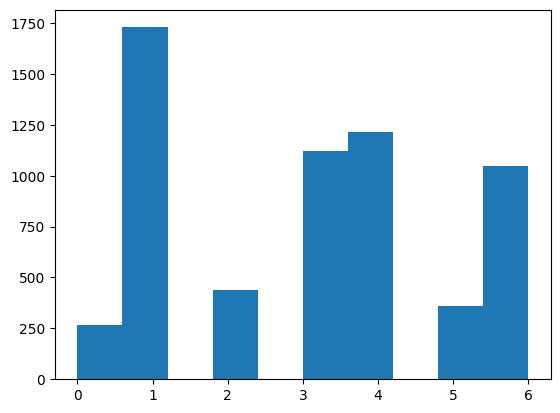

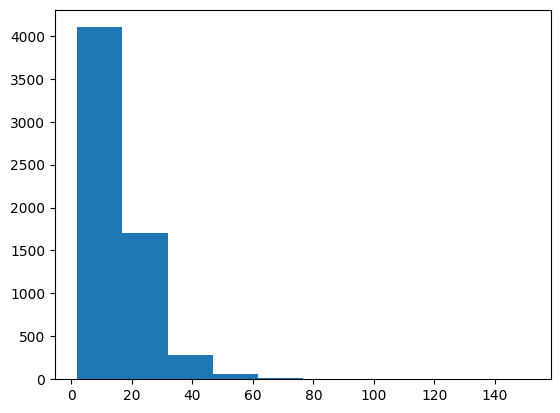

In [47]:
plt.hist(new_train_frame['Emotion'])
plt.show()
plt.hist(new_train_frame['Sentence'].apply(len))
plt.show()

In [48]:
drop_lst = []
for i in new_train_frame.index[new_train_frame['Emotion']==emotion_to_num['Enjoyment']]:
  if np.random.uniform(0,1)<0.4:
    drop_lst.append(i)

drop_df = new_train_frame[new_train_frame.index.isin(drop_lst)]
train_df = new_train_frame.drop(new_train_frame.index[drop_lst])
test_df = pd.concat([test_frame,drop_df])

In [50]:
duplicate = new_train_frame[
    (new_train_frame['Emotion']==emotion_to_num['Anger']) |
    (new_train_frame['Emotion']==emotion_to_num['Fear']) |
    (new_train_frame['Emotion']==emotion_to_num['Surprise'])
]
train_df = pd.concat([train_df,duplicate,duplicate])

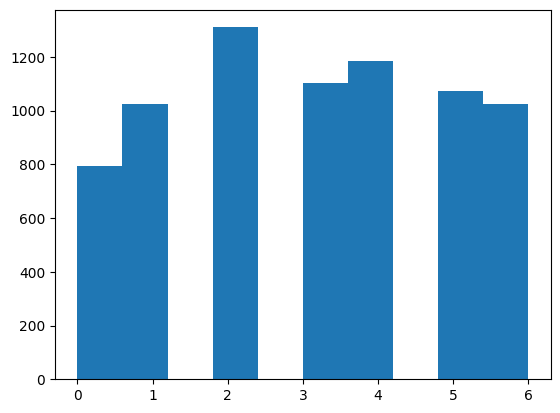

In [51]:
plt.hist(train_df['Emotion'])
plt.show()

# Training Model

In [52]:
emotion_to_num

{'Surprise': 0,
 'Enjoyment': 1,
 'Anger': 2,
 'Other': 3,
 'Disgust': 4,
 'Fear': 5,
 'Sadness': 6}

In [53]:
max_len = max(train_df['Sentence'].apply(len))
vocab_size  = len(key_to_index.keys())
category = len(emotion_to_num.keys())
category

7

In [54]:
embedding_size = model.wv.vectors.shape[-1]
embedding_weights = torch.tensor(model.wv.vectors)

In [66]:
class MyDataset(Dataset):
  def __init__(self, dataframe,vocab,unknown_token = '_unk_'):
    self.df = dataframe
    self.max_sequence_length = max(dataframe['Sentence'].apply(len))
    self.vocab = vocab
    self.unk = unknown_token
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    sentence = self.df.iloc[idx]['Sentence']
    emotion = self.df.iloc[idx]['Emotion']

    # Convert tokens to IDs using vocab
    sentence_ids = [self.vocab[token] if token in self.vocab.keys() else self.vocab[self.unk] for token in sentence]
    # Pad or truncate the sequence to the fixed length
    # if len(sentence_ids) < self.max_sequence_length:
    #     padded_sentence_ids = sentence_ids + [0] * (self.max_sequence_length - len(sentence_ids))
    # else:
    #     padded_sentence_ids = sentence_ids[:self.max_sequence_length]

    # sentence_tensor = torch.tensor(padded_sentence_ids)
    sentence_tensor = torch.tensor(sentence_ids)
    emotion_tensor = torch.tensor([emotion])
    sentence_size = torch.tensor(len(sentence_ids)-1)

    return sentence_tensor, emotion_tensor, sentence_size

In [67]:
trainset = MyDataset(train_df,key_to_index)
testset = MyDataset(test_df,key_to_index)

In [68]:
trainLoader = DataLoader(trainset,batch_size=1,shuffle=True,drop_last=True)
testLoader = DataLoader(testset,batch_size = 1)

In [84]:
class Encoder(nn.Module):
  def __init__(self,embedding_size,embedding_weight,hidden_size,hidden_layer):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_weight)
    self.embedding.requires_grad = False
    self.lstm_layer = nn.LSTM(embedding_size,hidden_size,hidden_layer,batch_first = True,bidirectional=True)
  def forward(self,x,h):
    y = self.embedding(x)
    y,h = self.lstm_layer(y,h)
    return y, (h[0].detach(),h[1].detach())
class Decoder(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_size,128),
        nn.LeakyReLU(),
        nn.Linear(128,64),
        nn.LeakyReLU(),
        nn.Linear(64,output_size),
        nn.LeakyReLU(),
        nn.Linear(output_size,output_size)
    )
  def forward(self,x):
    return self.model(x)

In [85]:
encoder = Encoder(embedding_size,embedding_weights,256,3)
decoder = Decoder(256*2,category)

In [93]:
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params,lr=1e-3)
lossfn = nn.CrossEntropyLoss()
epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu:0'
trainloss = np.zeros(epochs)
test_acc = np.zeros(epochs)
train_acc = np.zeros(epochs)
total_test_sample = len(testset)

In [ ]:
best_acc = 0
best_model = [Encoder(embedding_size,embedding_weights,256,3),Decoder(256*2,category)]
best_epoch = 0

In [94]:

encoder.to(device)
decoder.to(device)
for epoch in range(epochs):
  print(f'\r epoch: {epoch+1}/{epochs}',end='',flush=True)
  batch_loss = []
  batch_acc = []
  encoder.train()
  decoder.train()
  for x,y,l in trainLoader:
    batch = torch.arange(y.shape[0])
    x = x.to(device)
    y = y.to(device)

    yHat,_ = encoder(x,None)
    yHat = decoder(yHat[batch,l,:])
    loss = lossfn(yHat.squeeze(),y.squeeze())


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss.append(loss.cpu().detach().numpy())
    batch_acc.append((100*torch.mean((torch.argmax(yHat.cpu(),dim=-1) == y.cpu()).float())).detach().numpy())
  trainloss[epoch] = np.mean(batch_loss)
  train_acc[epoch] = np.mean(batch_acc)
  encoder.eval()
  decoder.eval()
  correct = 0
  for x,y,l in testLoader:
    batch = torch.arange(y.shape[0])
    x = x.to(device)
    y = y.to(device)
    yHat,_ = encoder(x,None)
    yHat = decoder(yHat[batch,l,:])
    if torch.argmax(yHat.cpu(),dim=-1) == y.cpu():
      correct+=1
  # test_acc[epoch] = (100*torch.mean((torch.argmax(yHat.cpu(),dim=-1) == y.cpu()).float())).detach().numpy()
  test_acc[epoch] = 100*correct/total_test_sample
  if test_acc[epoch] > best_acc:
    best_acc = test_acc[epoch]
    best_epoch = epoch
    best_model[0].load_state_dict(encoder.state_dict())
    best_model[1].load_state_dict(decoder.state_dict())

 epoch: 30/30

# TESTING

In [95]:
print(best_acc)
print(best_epoch)

60.84056037358239
27


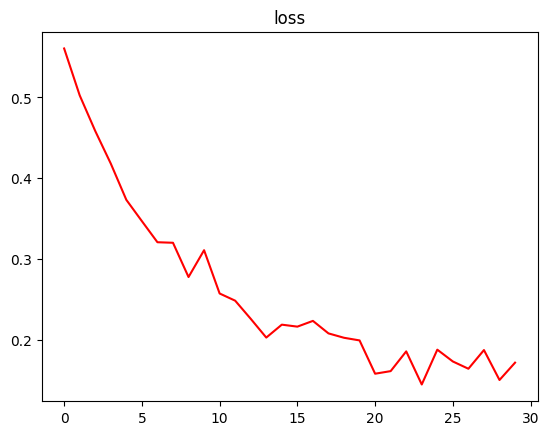

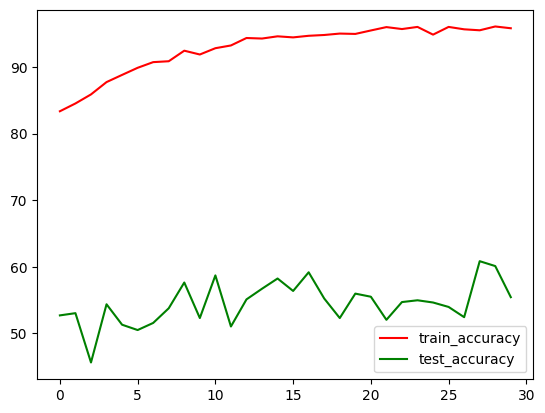

In [96]:
plt.plot(trainloss,'r-')
plt.title('loss')
plt.show()
plt.plot(train_acc, 'r-',label='train_accuracy')
plt.plot(test_acc,'g-',label='test_accuracy')
plt.legend()
plt.show()

In [110]:
#test with standard test set (no cut of ammout from train)
newTestDf = MyDataset(test_frame,key_to_index)
newTestDataLoader = DataLoader(newTestDf)
count = len(newTestDf)
cor = 0
for x,y,l in newTestDataLoader:
  yHat,_ = best_model[0](x,None)
  yHat = best_model[1](yHat[batch,l,:])
  if torch.argmax(yHat.cpu(),dim=-1) == y.cpu():
    cor+=1
cor/count

0.5281385281385281

In [113]:
y_true = []
y_pred = []
for x,y,l in testLoader:
  yHat,_ = best_model[0](x,None)
  yHat = best_model[1](yHat[batch,l,:])
  y_true.append(y.detach().squeeze().item())
  y_pred.append(torch.argmax(yHat,dim=-1).detach().squeeze().item())

In [115]:
f1_score(y_true, y_pred, average='weighted')

0.6343618717888054

In [127]:
cm = confusion_matrix(y_true, y_pred)
cm.dtype= float
for i in range(cm.shape[0]):
  cm[i,:] /= np.sum(cm[i,:],dtype=float)
cm*=100
cm

array([[45.65217391, 30.43478261,  0.        , 13.04347826, 10.86956522,
         0.        ,  0.        ],
       [ 1.00111235, 64.96106785,  0.44493882, 12.45828699, 13.45939933,
         1.44605117,  6.22914349],
       [ 0.        , 12.        , 38.        , 12.        , 26.        ,
         6.        ,  6.        ],
       [ 2.01342282, 19.46308725,  1.34228188, 49.66442953, 23.48993289,
         0.        ,  4.02684564],
       [ 0.625     , 10.625     ,  6.875     , 10.625     , 64.375     ,
         4.375     ,  2.5       ],
       [ 0.        ,  7.27272727,  3.63636364,  9.09090909, 16.36363636,
        60.        ,  3.63636364],
       [ 0.        ,  6.42857143,  1.42857143, 17.85714286, 15.        ,
         3.57142857, 55.71428571]])

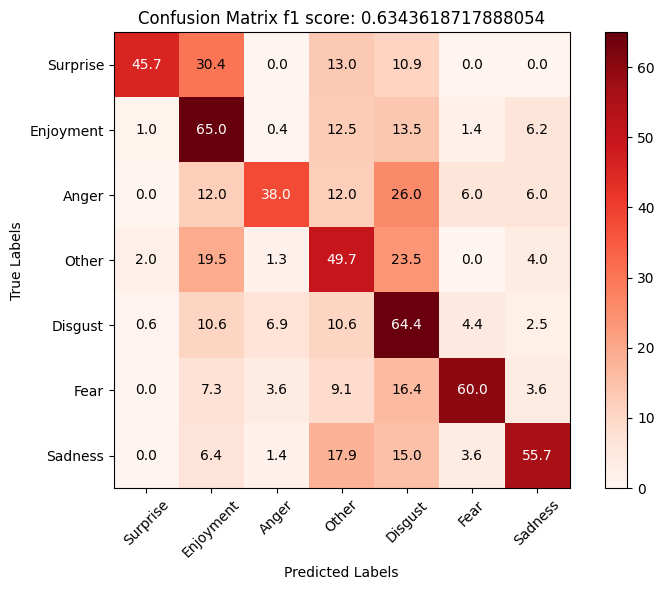

In [134]:
class_labels = [num_to_emotion[i] for i in range(7)]

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)


plt.colorbar()


tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix f1 score: {f1_score(y_true, y_pred, average="weighted")}')


for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, format(cm[i, j],'.1f'), ha='center', va='center', color='white' if cm[i, j] > 0.5*cm.max() else 'black')


plt.tight_layout()
plt.show()

In [135]:
text = 'Em mới chia tay với người yêu :('
token = preprocessEmoji(text)
token = tokenize(token)
print(token)
token_list = [key_to_index[i] if i in key_to_index.keys() else key_to_index['_unk_'] for i in token]
print(token_list)
input_tensor = torch.tensor(token_list)
y,h = best_model[0](input_tensor,None)
yHat = best_model[1](y[-1,:])
print(yHat)
print(num_to_emotion[torch.argmax(yHat).detach().item()])

['_s_', 'em', 'mới', 'chia_tay', 'với', 'người_yêu', '_disappointed_face_', '_e_']
[0, 41, 67, 454, 52, 172, 72, 1]
tensor([-13.1570,  -3.2725,  -5.5556,  -2.4555,  -0.6085,  -4.4023,   2.7068],
       grad_fn=<AddBackward0>)
Sadness


In [106]:
torch.save(best_model[0].state_dict(),PATH+"encoder.pth")
torch.save(best_model[1].state_dict(),PATH+"decoder.pth")